In [1]:
from starkit.gridkit import load_grid
from starkit.base.operations.spectrograph import (Interpolate, Normalize,
                                                  NormalizeParts,InstrumentConvolveGrating)
from starkit.base.operations.stellar import (RotationalBroadening, DopplerShift)
from starkit import assemble_model, operations
from scipy.interpolate import LinearNDInterpolator
import scipy
import numpy as np
from matplotlib import pyplot as plt
from specutils import Spectrum1D,rvmeasure
import astropy.units as u
from astropy.modeling import models,fitting
from astropy.modeling import Model
import matplotlib.pyplot as plt
from specutils import read_fits_file,plotlines,write_spectrum

In [2]:

grid = load_grid('/u/rbentley/metallicity/grids/bosz_t3500_7000_w20000_24000_R25000.h5')

points, values, wavelengths = grid.index.copy(), grid.fluxes.value.copy(), grid.wavelength.value.copy()

for i in range(len(points)):
    fit = np.polyfit(wavelengths, values[i], 1)
    values[i] = values[i] / (fit[0] * wavelengths + fit[1])

[starkit.gridkit.base][INFO   ]  Reading index (base.py:266)
[starkit.gridkit.base][INFO   ]  Discovered columns teff, logg, mh, alpha (base.py:269)
[starkit.gridkit.base][INFO   ]  Reading Fluxes (base.py:272)
[starkit.gridkit.base][INFO   ]  Fluxes shape (6790, 18233) (base.py:275)
[py.warnings         ][WARNING]  /u/rbentley/miniconda3/envs/starkit/lib/python2.7/site-packages/astropy/units/format/generic.py:461: UnitsWarning: 'erg/s/angstrom' contains multiple slashes, which is discouraged by the FITS standard
  core.UnitsWarning)
 (generic.py:461)
[starkit.gridkit.base][INFO   ]  Initializing spec grid (base.py:309)
[starkit.gridkit.base][WARNING]  **** NO WAVELENGTH TYPE SET DEFAULTING TO GRID (vacuum) ****

 (base.py:75)


In [3]:
removed_points = points[1]
removed_flux = values[1]

grid.fluxes = np.delete(values, 1, axis=0)
grid.index = np.delete(points, 1, axis=0)

In [4]:
starspectrum = Spectrum1D.from_array(dispersion=wavelengths, flux=removed_flux,
                                           dispersion_unit=u.angstrom,
                                           uncertainty=removed_flux*(1/100.))

In [5]:
interp1 = Interpolate(starspectrum)
rot1 = RotationalBroadening.from_grid(grid, vrot=np.array([10.0]))
norm1 = Normalize(starspectrum, 2)

model = grid | rot1 | DopplerShift(vrad=0) | interp1 | norm1

setattr(model, 'teff_0', removed_points[0])
setattr(model, 'logg_0', removed_points[1])
setattr(model, 'mh_0', removed_points[2])
setattr(model, 'alpha_0', removed_points[3])

w1, f1 = model()

res1 = starspectrum.flux.value - f1


[py.warnings         ][WARNING]  /u/rbentley/miniconda3/envs/starkit/lib/python2.7/site-packages/starkit/base/operations/spectrograph.py:192: UserWarning: The fit may be poorly conditioned
  warnings.warn(msg)
 (spectrograph.py:192)


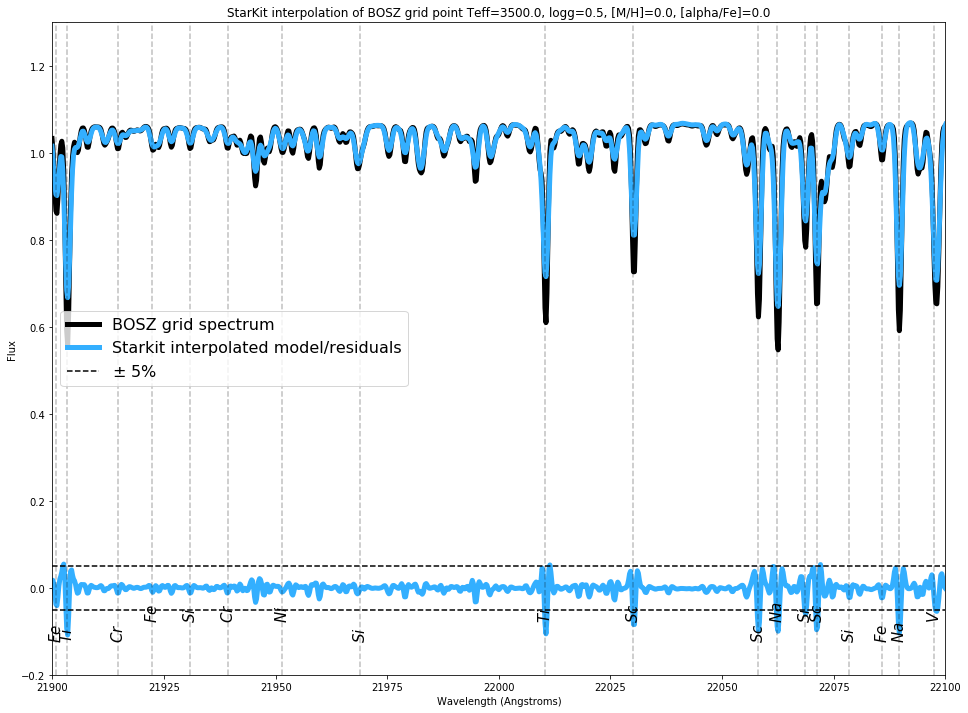

In [14]:
plt.figure(figsize=(16, 12))


plt.plot(wavelengths, removed_flux, label='BOSZ grid spectrum',
                     color='#000000', linewidth=5.0)

plt.plot(w1, f1, color='#33AFFF', linewidth=5.0)

plt.plot(w1, res1, label='Starkit interpolated model/residuals',
                    color='#33AFFF', linewidth=5.0)


plt.axhline(y=0.05, color='k', linestyle='--', label='$\pm$ 5%')
plt.axhline(y=-0.05, color='k', linestyle='--')

plt.xlim(21900, 22100)

plt.ylim(-0.2, 1.3)


plt.legend(loc='center left', fontsize=16)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('StarKit interpolation of BOSZ grid point Teff='+str(removed_points[0])+', logg='+str(removed_points[1])+\
          ', [M/H]='+str(removed_points[2])+', [alpha/Fe]='+str(removed_points[3]))
plotlines.oplotlines(angstrom=True, arcturus=True, alpha=0.25, molecules=False, size=15)